In [3]:
import numpy as np
import scipy.io as sio
import glob
from sklearn import linear_model
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
from itertools import cycle
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy import stats
from scipy import ndimage
import pystan
from matplotlib import cm

%matplotlib inline

color_cycle = cycle(['g', 'b', 'c', 'm', 'y', 'k'])


import warnings
warnings.simplefilter("ignore")


import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

color_cycle = cycle(['g', 'b', 'c', 'm', 'y', 'k'])


import sys
sys.path.append('C:\\Users\\adamimos\\Documents\\GitHub\\ASAC\\python')
from import_rat_data import *
from behavior_analysis import *
#from decoder_functions import *

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


behavior camera sync signal found and loaded
the number of frames according to the sync signal is: 33852.0
261
[   -635.65595318    -631.75601268    -627.85607216 ...,  133929.43942932
  133933.33937008  133937.23931102]
33852


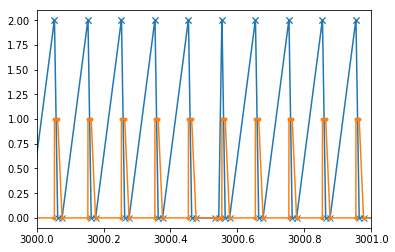

In [13]:
# LOAD ALL DATA

directory = 'G:\\centerhold_20190801\\'
#directory = 'G:\\centerhold_20190712\\'
#directory = 'G:\\adam0_20190705\\'
behavior_files = glob.glob(directory+'*.pickle')
frame_files = glob.glob(directory+'*.csv')

behavior_data = []
frame_data = []

for b in behavior_files:
    file = open(b,'rb')
    behavior_data.append(pickle.load(file))
    file.close()   

for f in frame_files:
    frame_data.append(get_frame_data(f))

try:
    traces = sio.loadmat(glob.glob(directory+'*traces.mat')[0])['traces']
except:
    traces = sio.loadmat(glob.glob(directory+'*traces.mat')[0])['traces_']

In [21]:
was_completed = []
was_correct = []
stim_noise = []
correct_side = []
stim_dir = []
response_side = []
prior = []
spf = []
ssf = []
sef = []
rf = []
stim_type = []
pattern_inds = []
patterns = []

frame_offset = np.cumsum(0)
frame_offset = np.roll(frame_offset,1)
frame_offset[0]=0
for i in range(len(behavior_data)):
    bd = behavior_data[i]
    fd = frame_data[i]
    ft = bd['final_trial']+1
        
    was_completed.extend(bd['was_completed'][0:ft])
    was_correct.extend(bd['was_correct'][0:ft])
    stim_noise.extend(bd['coherence'][0:ft])
    #stim_type.extend(bd['stim_type'][0:ft])
    stim_dir.extend(bd['stim_dir'][0:ft])
    correct_side.extend(bd['stim_dir'][0:ft])
    response_side.extend(bd['response_side'][0:ft])
    prior.extend(bd['rightward_prior'][0:ft])
    ssf.extend(fd['stim_start_frames']+frame_offset[i])
    spf.extend(fd['start_poke_frames']+frame_offset[i])
    sef.extend(fd['stim_end_frames']+frame_offset[i])
    rf.extend(fd['response_frames']+frame_offset[i])
    #pattern_inds.extend(bd['pattern_inds_played'][0:ft])
    #patterns.extend(bd['patterns'])
    

In [23]:
traces_stim_aligned = []
traces_resp_aligned = []
completed_inds = []


k = 0
for ind in range(len(was_completed)):
    if was_completed[ind]==1:
    #if not np.isnan(rf[ind]) and not np.isnan(ssf[ind]): # CAHNGED FOR CENTER HOLD
        k=k+1
        traces_stim_aligned.append(traces[:,np.arange(ssf[ind]-40,ssf[ind]+80,1).astype(int)])
        traces_resp_aligned.append(traces[:,np.arange(rf[ind]-60,rf[ind]+60,1).astype(int)])
        completed_inds.append(ind)
        
traces_stim_aligned = np.array(traces_stim_aligned)
traces_resp_aligned = np.array(traces_resp_aligned)

completed_inds = np.array(completed_inds)

In [24]:
all_data = {'was_completed':np.array(was_completed),
           'was_correct':np.array(was_correct),
           'stim_dir':np.array(stim_dir),
           'correct_side':np.array(correct_side),
           'response_side':np.array(response_side),
            'prior':np.array(prior),
            'noise':np.array(stim_noise),
            #'stim_type':np.array(stim_type),
           'traces':traces,
           'task_info':behavior_data[0]['info'],
           'frame_info':{'stim_start_frame':np.array(ssf),
                   'start_poke_frame':np.array(spf),
                   'stim_end_frame':np.array(sef),
                   'response_frame':np.array(rf)},
            #'patterns':np.array(patterns),
            #'pattern_inds':np.array(pattern_inds)
           }

ci = np.where(np.array(was_completed))
ci = completed_inds # CHANGED FOR CENTER HOLD
completed_trials_data = {'was_completed':np.array(was_completed)[ci],
           'was_correct':np.array(was_correct)[ci],
           'stim_dir':np.array(stim_dir)[ci],
           'correct_side':np.array(correct_side)[ci],
            'prior':np.array(prior)[ci],
            'noise':np.array(stim_noise)[ci],
            #'stim_type':np.array(stim_type)[ci],
           'response_side':np.array(response_side)[ci],
            'traces_stim_aligned':traces_stim_aligned,
            'traces_resp_aligned':traces_resp_aligned,
            'completed_inds':ci,
            'frame_info':{'stim_start_frame':np.array(ssf)[ci],
                   'start_poke_frame':np.array(spf)[ci],
                   'stim_end_frame':np.array(sef)[ci],
                   'response_frame':np.array(rf)[ci]},
            #        'patterns':np.array(patterns),
            #'pattern_inds':np.array(pattern_inds)[ci]
            }

data = {'all_data':all_data,'completed_trials_data':completed_trials_data}

pickle.dump( data, open( "adam0_20190801.pickle", "wb" ) )

array(['right', 'left', 'right', 'right', 'right', 'right', 'left', 'left',
       'right', 'left', 'right', 'right', 'right', 'left', 'left', 'right',
       'left', 'right', 'left', 'left', 'left', 'right', 'left', 'left',
       'right', 'left', 'right', 'right', 'left', 'right', 'left', 'left',
       'right', 'right', 'right', 'left', 'left', 'left', 'right', 'left',
       'left', 'left', 'left', 'right', 'left', 'left', 'right', 'right',
       'right', 'right', 'left', 'right', 'right', 'right', 'right',
       'left', 'left', 'right', 'left', 'left', 'right', 'right', 'left',
       'left', 'left', 'right', 'left', 'left', 'left', 'right', 'right',
       'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left',
       'left', 'left', 'left', 'right', 'left', 'right', 'right', 'right',
       'right', 'right', 'left', 'left', 'right', 'right', 'right', 'left',
       'left', 'right', 'left', 'left', 'right', 'left', 'right', 'left',
       'right', 'left', 'right', 

# Load Data and Analyze

In [ ]:
data['all_data'].keys()

In [82]:
file = open("Adam0_20190524.pickle",'rb')
data = pickle.load(file)
file.close()   

In [ ]:
import cv2
cap = cv2.VideoCapture('H:\\adam0_20190516\\adam0.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, data['all_data']['frame_info']['stim_start_frame'][20]-5)


#Read the next frame from the video. If you set frame 749 above then the code will return the last frame.
ig = plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    ret, frame = cap.read()
    plt.imshow(frame)
cap.release()
cv2.destroyAllWindows()

In [178]:
cap = cv2.VideoCapture('H:\\adam0_20190516\\adam0.avi')
k = 0


while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    k = k+1

    if np.mod(k,1000)==0:
        print(k)
    


cap.release()
cv2.destroyAllWindows()
print(k)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
29940


In [140]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
cap = cv2.VideoCapture('H:\\adam0_20190516\\adam0.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, data['all_data']['frame_info']['start_poke_frame'][0]-5)
fig, ax = plt.subplots()
l, = ax.plot([],[])

def animate(i):
    ret, frame = cap.read()
    l.set_data(frame)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=20)
fig.show()

In [141]:
ani

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


ValueError: too many values to unpack (expected 2)

In [20]:
import matplotlib.pylab as pl

def plot_av_dir_traces(n):
    #fig = plt.figure(figsize=(20,7))
    colors = pl.cm.RdBu(np.linspace(0,1,dir_av_traces1_stim.shape[0]))
    #plt.subplot(1,2,1)
    for x in range(av_traces.shape[0]):
        plt.plot(np.squeeze(av_traces1[x,n,:]),color = colors[d])  
    plt.plot([35,35],[0,np.max(np.ravel(av_traces[:,n,:]))],'--k')
    plt.plot([40,40],[0,np.max(np.ravel(av_traces[:,n,:]))],'--k')
    plt.plot([47,47],[0,np.max(np.ravel(av_traces[:,n,:]))],'--k')
    plt.xticks([35,43], ['poke','stim'])
    plt.xlim([20,60])

In [49]:
independent_variable1 = data['completed_trials_data']['stim_dir']
data_to_avg1 = data['completed_trials_data']['traces_stim_aligned']
av_traces1 = []
for x in np.unique(independent_variable1):
    av_traces1.append(np.mean(data_to_avg1[np.where(independent_variable1==x)[0],:,:],axis=0))
av_traces1 = np.array(av_traces1)



In [50]:
independent_variable2 = data['completed_trials_data']['response_side']
data_to_avg2 = data['completed_trials_data']['traces_resp_aligned']
av_traces2 = []
for x in np.unique(independent_variable2):
    av_traces2.append(np.mean(data_to_avg2[np.where(independent_variable2==x)[0],:,:],axis=0))
av_traces2 = np.array(av_traces2)

In [96]:
dp = np.where(data['completed_trials_data']['stim_type']=='plaid')
independent_variable1 = data['completed_trials_data']['stim_dir'][dp]
data_to_avg1 = data['completed_trials_data']['traces_stim_aligned'][dp]
av_traces1 = []
for x in np.unique(independent_variable1):
    av_traces1.append(np.mean(data_to_avg1[np.where(independent_variable1==x)[0],:,:],axis=0))
av_traces1 = np.array(av_traces1)



In [97]:
dg = np.where(data['completed_trials_data']['stim_type']=='grating')
independent_variable2 = data['completed_trials_data']['stim_dir'][dg]
data_to_avg2 = data['completed_trials_data']['traces_stim_aligned'][dg]
av_traces2 = []
for x in np.unique(independent_variable2):
    av_traces2.append(np.mean(data_to_avg2[np.where(independent_variable2==x)[0],:,:],axis=0))
av_traces2 = np.array(av_traces2)

In [75]:
directions = np.array(direction)[ci]
dir_av_traces_stim = []
dir_av_traces_resp = []
for d in np.unique(directions):
    dir_av_traces_stim.append(np.mean(traces_stim_aligned[np.where(directions==d)[0],:,:],axis=0))
    dir_av_traces_resp.append(np.mean(traces_resp_aligned[np.where(directions==d)[0],:,:],axis=0))
dir_av_traces_stim = np.array(dir_av_traces_stim)
dir_av_traces_resp = np.array(dir_av_traces_resp)

In [14]:
import matplotlib.pylab as pl

def plot_av_dir_traces(n):
    #fig = plt.figure(figsize=(20,7))
    colors = pl.cm.RdBu(np.linspace(0,1,av_traces1.shape[0]))
    #plt.subplot(1,2,1)
    for d in range(av_traces1.shape[0]):
        plt.plot(np.squeeze(av_traces1[d,n,:]),color = colors[d])  
    plt.plot([35,35],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.plot([40,40],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.plot([47,47],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.xticks([35,43], ['poke','stim'])
    plt.xlim([20,80])
    
    #plt.subplot(1,2,2)
    #for d in range(dir_av_traces_resp.shape[0]):
    #    plt.plot(np.squeeze(dir_av_traces_resp[d,n,:]),color = colors[d])  
    #plt.plot([60,60],[0,np.max(np.ravel(dir_av_traces_resp[:,n,:]))],'--k')
    #plt.plot([60,60],[0,1])
    #plt.xticks([60], ['response'])

    

In [99]:
data_to_avg.shape[1

SyntaxError: unexpected EOF while parsing (<ipython-input-99-1bdd3fff3ee9>, line 1)

In [15]:
interact(plot_av_dir_traces,n=widgets.IntSlider(min=0,max=data_to_avg1.shape[1]-1,step=1,value=0))

interactive(children=(IntSlider(value=1, description='n', max=184), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_av_dir_traces(n)>

In [58]:
def plot_polar_plots(n):
    theta = (np.arange(0,2*np.pi,np.pi/4))
    theta = np.append(theta, 0)
    stim_av = np.squeeze(dir_av_traces_stim[:,n,60:70]).mean(axis=1)
    pstim_av = np.squeeze(dir_av_traces_stim[:,n,20:30]).mean(axis=1)
    ppstim_av = np.squeeze(dir_av_traces_stim[:,n,40:48]).mean(axis=1)
    plt.polar(theta,np.append(stim_av,stim_av[0]),'g')
    plt.polar(theta,np.append(pstim_av,pstim_av[0]),'k')
    plt.polar(theta,np.append(ppstim_av,ppstim_av[0]),'r')

In [53]:
interact(plot_polar_plots,n=widgets.IntSlider(min=0,max=dir_av_traces_stim.shape[1],step=1,value=10))

interactive(children=(IntSlider(value=10, description='n', max=399), Output()), _dom_classes=('widget-interact…

<function __main__.plot_polar_plots(n)>

In [100]:
def plot_rasters(n):
    fig = plt.figure(figsize=(20,14))
    plt.subplot(2,2,1)
    plt.imshow(data_to_avg1[np.argsort(independent_variable1),n,:],aspect='auto')
    plt.xlim([20,80])
    
    plt.subplot(2,2,2)
    plt.imshow(data_to_avg2[np.argsort(independent_variable2),n,:],aspect='auto')
    plt.xlim([20,80])
    
    colors = pl.cm.RdBu(np.linspace(0,1,av_traces1.shape[0]))
    plt.subplot(2,2,3)
    for d in range(av_traces1.shape[0]):
        plt.plot(np.squeeze(av_traces1[d,n,:]),color = colors[d])  
    plt.plot([35,35],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.plot([40,40],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.plot([47,47],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.xticks([35,43], ['poke','stim'])
    plt.xlim([20,80])
    
    colors = pl.cm.RdBu(np.linspace(0,1,av_traces2.shape[0]))
    plt.subplot(2,2,4)
    for d in range(av_traces2.shape[0]):
        plt.plot(np.squeeze(av_traces2[d,n,:]),color = colors[d])  
    plt.plot([35,35],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.plot([40,40],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.plot([47,47],[0,np.max(np.ravel(av_traces1[:,n,:]))],'--k')
    plt.xticks([35,43], ['poke','stim'])
    plt.xlim([20,80])
    
    
    plt.xticks([60], ['response'])
    plt.xlim([20,80])


In [40]:
def plot_rasters(n):
    plt.imshow(traces_stim_aligned[:,n,:],aspect='auto')

In [101]:
interact(plot_rasters,n=widgets.IntSlider(min=0,max=av_traces2.shape[1],step=1,value=0))

interactive(children=(IntSlider(value=0, description='n', max=323), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_rasters(n)>

In [61]:
def all_plots(n):
    fig = plt.figure(figsize=(20,10))
    fig.add_subplot(131)
    plot_rasters(n)
    fig.add_subplot(132)
    plot_av_dir_traces(n)
    fig.add_subplot(133,projection='polar')
    plot_polar_plots(n)

interactive(children=(IntSlider(value=10, description='n', max=399), Output()), _dom_classes=('widget-interact…

<function __main__.all_plots(n)>

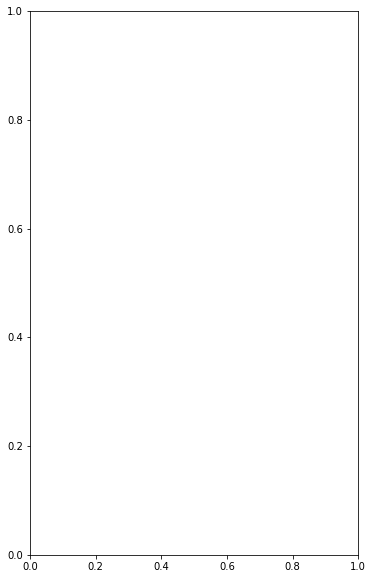

In [62]:
interact(all_plots,n=widgets.IntSlider(min=0,max=dir_av_traces_stim.shape[1],step=1,value=10))

In [23]:
np.mean(data['completed_trials_data']['was_correct'][np.where(data['completed_trials_data']['stim_dir']=='right')])


0.77430555555555558

In [92]:
def plot_coherence_tuning(n):
    to_plot = []
    err = []
    for c in np.unique(directions):
        to_plot.append(t_data[np.where(directions==c)[0],n,22:27].mean(axis=0).mean(axis=0))
        err.append(t_data[np.where(directions==c)[0],n,22:27].mean(axis=0).std(axis=0))
    plt.errorbar(np.unique(directions),to_plot,err)

In [93]:
interact(plot_coherence_tuning,n=widgets.IntSlider(min=0,max=dir_av_traces.shape[1],step=1,value=10))

interactive(children=(IntSlider(value=10, description='n', max=115), Output()), _dom_classes=('widget-interact…

<function __main__.plot_coherence_tuning(n)>

In [45]:
np.where(directions==1.)[0]

array([ 10,  65,  79,  93, 100, 116, 119, 137, 142, 148, 152, 185, 189,
       194, 201, 204, 213, 224, 236, 255, 264, 272], dtype=int64)

In [58]:
directions

array([ 0.45,  0.45,  0.1 ,  0.45,  0.45,  0.25,  0.45,  0.7 ,  0.45,
        0.45,  1.  ,  0.45,  0.7 ,  0.7 ,  0.45,  0.25,  0.1 ,  0.7 ,
        0.1 ,  0.7 ,  0.45,  0.25,  0.7 ,  0.25,  0.7 ,  0.45,  0.45,
        0.45,  0.1 ,  0.25,  0.1 ,  0.1 ,  0.25,  0.25,  0.45,  0.7 ,
        0.25,  0.45,  0.25,  0.25,  0.45,  0.1 ,  0.7 ,  0.25,  0.25,
        0.7 ,  0.25,  0.25,  0.7 ,  0.45,  0.7 ,  0.45,  0.25,  0.25,
        0.1 ,  0.25,  0.1 ,  0.45,  0.25,  0.7 ,  0.1 ,  0.1 ,  0.1 ,
        0.1 ,  0.7 ,  1.  ,  0.45,  0.1 ,  0.1 ,  0.45,  0.45,  0.1 ,
        0.7 ,  0.1 ,  0.45,  0.25,  0.25,  0.1 ,  0.1 ,  1.  ,  0.1 ,
        0.1 ,  0.25,  0.45,  0.25,  0.45,  0.1 ,  0.7 ,  0.1 ,  0.1 ,
        0.1 ,  0.25,  0.45,  1.  ,  0.7 ,  0.45,  0.45,  0.7 ,  0.25,
        0.1 ,  1.  ,  0.1 ,  0.7 ,  0.25,  0.45,  0.25,  0.25,  0.1 ,
        0.45,  0.7 ,  0.7 ,  0.1 ,  0.7 ,  0.1 ,  0.1 ,  0.1 ,  1.  ,
        0.45,  0.25,  1.  ,  0.25,  0.1 ,  0.7 ,  0.25,  0.7 ,  0.1 ,
        0.7 ,  0.25,

In [22]:


start_poke_frames1 = start_poke_frames[completed_inds]
ssf1 = ssf[completed_inds]
sef1 = sef[completed_inds]
rf1 = rf[completed_inds]
data = pd.DataFrame.from_dict({'start_poke_frame':start_poke_frames1,'stim_start_frame':ssf1,'stim_end_frame':sef1,'reward_frame':rf1})


# pre-nosepoke to end of nosepoke (500 ms before nosepoke to 500 ms after nosepoke; 10 frames total)
pt_start_inds = np.array(data.start_poke_frame.tolist())-5 # 500 ms before nosepoke
pt_frames = np.tile(np.array(pt_start_inds),(10,1)).T+np.tile(np.arange(10),(len(pt_start_inds),1)) # the 500 ms before the nosepoke
pt_traces = trace_data[:,pt_frames.astype(int)]

# stimulus (10 frames total)
stim_start_inds = np.array(data.stim_start_frame.tolist())
stim_end_inds = np.array(data.stim_end_frame.tolist())
stim_inds = [np.arange(stim_start_inds[x],stim_end_inds[x]) for x in range(len(stim_start_inds))]

nnn=[]
for n in range(trace_data.shape[0]):
    ttt =[]
    for t in range(len(stim_inds)):
        td = trace_data[n,stim_inds[t].astype(int)]
        ttt.append(np.interp(np.arange(0,10),np.linspace(0,10,len(td)),td)) #make the stimulus 1 second
    nnn.append(ttt)
stim_traces = np.squeeze(np.array(nnn))


# between stim and response (500 ms, 5 frames total)
resp_inds = np.array(data.reward_frame.tolist())
btw_inds = [np.arange(stim_end_inds[x],resp_inds[x]) for x in range(len(stim_end_inds))]

nnn=[]
for n in range(trace_data.shape[0]):
    ttt =[]
    for t in range(len(btw_inds)):
        td = trace_data[n,btw_inds[t].astype(int)]
        ttt.append(np.interp(np.arange(0,5),np.linspace(0,5,len(td)),td))
    nnn.append(ttt)
btw_traces = np.squeeze(np.array(nnn))


# response (10 frames total)
resp_frames = np.tile(np.array(resp_inds),(10,1)).T+np.tile(np.arange(10),(len(resp_inds),1))
resp_traces = trace_data[:,resp_frames.astype(int)]

interp_traces = np.concatenate((pt_traces,stim_traces,btw_traces,resp_traces),axis=2)

for i in range(interp_traces.shape[0]):
    for j in range(interp_traces.shape[1]):

        interp_traces[i,j,:]=ndimage.filters.gaussian_filter(interp_traces[i,j,:],1)


In [21]:
completed_inds = completed_inds[0:-2]

In [23]:
interp_traces.shape

(115, 277, 35)

In [30]:
noise = data['coherence'][completed_inds]

In [31]:
was_correct = data['was_correct'][completed_inds]

In [36]:
stim_dir = data['stim_dir']

In [42]:
coherence = np.array(coherence)

In [43]:
coherence = coherence[0:-2]

In [44]:
noise = coherence

In [45]:
import pickle
anton1_20190416 ={'noise':noise,'interp_traces':interp_traces,'was_correct':was_correct,'stim_dir':stim_dir}

In [46]:
pickle.dump( anton1_20190416, open( "anton1_20190416.pickle", "wb" ) )

In [ ]:
    frame_data = pd.read_csv(input_file)

    frame_data_diff = frame_data.diff()


    time = frame_data['Time[s]'].values
    ms_sig = frame_data[' miniscope_sync'].values
    st_sig = frame_data[' new_trial'].values
    cnp_sig = frame_data[' center_poke_start'].values
    stim_sig = frame_data[' stimulus'].values
    resp_sig = frame_data[' response'].values

    frame_num = frame_data_diff.replace({-1.0:0}).cumsum()[' miniscope_sync'].values


    def find_pulses(time,array,frame_num,min_pulse_dur=1):

        rise_inds = np.where(np.diff(array)==1)[0]+1
        fall_inds = np.where(np.diff(array)==-1)[0]+1

        rise_times = time[rise_inds]
        fall_times = time[fall_inds]

        pulse_durs = (fall_times-rise_times)*1000

        true_pulse_inds = np.where(pulse_durs>min_pulse_dur)

        rise_inds = rise_inds[true_pulse_inds]
        fall_inds = fall_inds[true_pulse_inds]
        rise_times = rise_times[true_pulse_inds]
        fall_times = fall_times[true_pulse_inds]
        pulse_durs = pulse_durs[true_pulse_inds]

        start_pulse_frame = frame_num[rise_inds]
        end_pulse_frame = frame_num[fall_inds]


        return {'rise_inds':rise_inds, 'fall_inds':fall_inds, 'rise_times':rise_times,
                'fall_times':fall_times, 'pulse_durs':pulse_durs,
                'start_pulse_frame':start_pulse_frame, 'end_pulse_frame':end_pulse_frame}



    # FIND INITIAL CENTER NOSEPOKE FRAMES
    start_poke_frames = find_pulses(time,cnp_sig,frame_num)['start_pulse_frame']
    start_poke_inds = find_pulses(time,cnp_sig,frame_num)['rise_inds']


    # FIND POTENTIAL STIM STARTS
    stim_start_frames = find_pulses(time,stim_sig,frame_num)['start_pulse_frame']
    stim_start_inds = find_pulses(time,stim_sig,frame_num)['rise_inds']

    # FIND POTENTIAL STIM ENDS
    stim_end_frames = find_pulses(time,stim_sig,frame_num)['end_pulse_frame']
    stim_end_inds = find_pulses(time,stim_sig,frame_num)['fall_inds']

    # FIND POTENTIAL RESPONSE PHASE TIMES
    response_frames = find_pulses(time,resp_sig,frame_num)['start_pulse_frame']
    response_inds = find_pulses(time,resp_sig,frame_num)['rise_inds']

    # GET FRAMES FOR EVERY TRIAL
    ssf = []
    sef = []
    rf = []
    for sp in start_poke_frames:
        try:
            ssf.append(stim_end_frames[np.where(stim_start_frames>sp)][0])
        except:
            ssf.append(np.nan)
        try:
            sef.append(stim_end_frames[np.where(stim_end_frames>sp)][0])
        except:
            sef.append(np.nan)
        try:
            rf.append(response_frames[np.where(response_frames>sp)][0])
        except:
            rf.append(np.nan)


    ssf = np.array(ssf)
    sef = np.array(sef)
    rf = np.array(rf)

    for ind in range(len(ssf)-1):
        if ssf[ind]>start_poke_frames[ind+1]:
            ssf[ind]=np.nan
        if sef[ind]>start_poke_frames[ind+1]:
            sef[ind]=np.nan
        if rf[ind]>start_poke_frames[ind+1]:
            rf[ind]=np.nan


    return {'start_poke_frames': start_poke_frames,'stim_start_frames':ssf,'stim_end_frames':sef,'response_frames':rf}


In [33]:
info_str = '''Trial 0 . Prior [0.5, 0.5] . Stim left . Coherence 1 [0, 14]
Incorrect Response. 0 / 1 = 0.0 %
Trial 1 . Prior [0.5, 0.5] . Stim right . Coherence 1 [14, 26]
Incorrect Response. 0 / 2 = 0.0 %
Trial 2 . Prior [0.5, 0.5] . Stim left . Coherence 1 [26, 33]
Correct Response. 1 / 3 = 33.333333333333336 %
Trial 3 . Prior [0.5, 0.5] . Stim left . Coherence 1 [33, 38]
Correct Response. 2 / 4 = 50.0 %
Trial 4 . Prior [0.5, 0.5] . Stim left . Coherence 1 [38, 43]
Correct Response. 3 / 5 = 60.0 %
Trial 5 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 6 . Prior [0.5, 0.5] . Stim left . Coherence 1 [47, 56]
Incorrect Response. 3 / 6 = 50.0 %
Trial 7 . Prior [0.5, 0.5] . Stim right . Coherence 1 [56, 63]
Incorrect Response. 3 / 7 = 42.857142857142854 %
Trial 8 . Prior [0.5, 0.5] . Stim left . Coherence 1 [63, 70]
Correct Response. 4 / 8 = 50.0 %
Trial 9 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted Before Stimulus
Trial 10 . Prior [0.5, 0.5] . Stim left . Coherence 1 [70, 76]
Correct Response. 5 / 9 = 55.55555555555556 %
Trial 11 . Prior [0.5, 0.5] . Stim left . Coherence 1 [76, 84]
Correct Response. 6 / 10 = 60.0 %
Trial 12 . Prior [0.5, 0.5] . Stim right . Coherence 1 [84, 91]
Incorrect Response. 6 / 11 = 54.54545454545455 %
Trial 13 . Prior [0.5, 0.5] . Stim left . Coherence 1 [91, 97]
Incorrect Response. 6 / 12 = 50.0 %
Trial 14 . Prior [0.5, 0.5] . Stim right . Coherence 1 [97, 103]
Incorrect Response. 6 / 13 = 46.15384615384615 %
Trial 15 . Prior [0.5, 0.5] . Stim left . Coherence 1 [103, 113]
Correct Response. 7 / 14 = 50.0 %
Trial 16 . Prior [0.5, 0.5] . Stim left . Coherence 1 [113, 121]
Correct Response. 8 / 15 = 53.333333333333336 %
Trial 17 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 18 . Prior [0.5, 0.5] . Stim left . Coherence 1 [124, 129]
Incorrect Response. 8 / 16 = 50.0 %
Trial 19 . Prior [0.5, 0.5] . Stim right . Coherence 1 [129, 133]
Incorrect Response. 8 / 17 = 47.05882352941177 %
Trial 20 . Prior [0.5, 0.5] . Stim left . Coherence 1 [133, 139]
Incorrect Response. 8 / 18 = 44.44444444444444 %
Trial 21 . Prior [0.5, 0.5] . Stim right . Coherence 1 [139, 144]
Incorrect Response. 8 / 19 = 42.10526315789474 %
Trial 22 . Prior [0.5, 0.5] . Stim right . Coherence 1 [144, 157]
Incorrect Response. 8 / 20 = 40.0 %
Trial 23 . Prior [0.5, 0.5] . Stim right . Coherence 1 [157, 164]
Incorrect Response. 8 / 21 = 38.095238095238095 %
Trial 24 . Prior [0.5, 0.5] . Stim right . Coherence 1 [164, 171]
Incorrect Response. 8 / 22 = 36.36363636363637 %
Trial 25 . Prior [0.5, 0.5] . Stim left . Coherence 1 [171, 180]
Correct Response. 9 / 23 = 39.130434782608695 %
Trial 26 . Prior [0.5, 0.5] . Stim right . Coherence 1 [180, 185]
Incorrect Response. 9 / 24 = 37.5 %
Trial 27 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 28 . Prior [0.5, 0.5] . Stim right . Coherence 1 [188, 195]
Incorrect Response. 9 / 25 = 36.0 %
Trial 29 . Prior [0.5, 0.5] . Stim right . Coherence 1 [195, 201]
Correct Response. 10 / 26 = 38.46153846153846 %
Trial 30 . Prior [0.5, 0.5] . Stim right . Coherence 1 [201, 206]
Correct Response. 11 / 27 = 40.74074074074074 %
Trial 31 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 32 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 33 . Prior [0.5, 0.5] . Stim left . Coherence 1 [209, 215]
Incorrect Response. 11 / 28 = 39.285714285714285 %
Trial 34 . Prior [0.5, 0.5] . Stim right . Coherence 1 [215, 220]
Incorrect Response. 11 / 29 = 37.93103448275862 %
Trial 35 . Prior [0.5, 0.5] . Stim left . Coherence 1 [220, 227]
Correct Response. 12 / 30 = 40.0 %
Trial 36 . Prior [0.5, 0.5] . Stim left . Coherence 1 [227, 234]
Correct Response. 13 / 31 = 41.935483870967744 %
Trial 37 . Prior [0.5, 0.5] . Stim left . Coherence 1 [234, 240]
Correct Response. 14 / 32 = 43.75 %
Trial 38 . Prior [0.5, 0.5] . Stim right . Coherence 1 [240, 247]
Incorrect Response. 14 / 33 = 42.42424242424242 %
Trial 39 . Prior [0.5, 0.5] . Stim left . Coherence 1 [247, 253]
Correct Response. 15 / 34 = 44.11764705882353 %
Trial 40 . Prior [0.5, 0.5] . Stim left . Coherence 1 [253, 266]
Correct Response. 16 / 35 = 45.714285714285715 %
Trial 41 . Prior [0.5, 0.5] . Stim left . Coherence 1 [266, 278]
Correct Response. 17 / 36 = 47.22222222222222 %
Trial 42 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 43 . Prior [0.5, 0.5] . Stim right . Coherence 1 [280, 289]
Incorrect Response. 17 / 37 = 45.945945945945944 %
Trial 44 . Prior [0.5, 0.5] . Stim right . Coherence 1 [289, 295]
Correct Response. 18 / 38 = 47.36842105263158 %
Trial 45 . Prior [0.5, 0.5] . Stim right . Coherence 1 [295, 301]
Correct Response. 19 / 39 = 48.717948717948715 %
Trial 46 . Prior [0.5, 0.5] . Stim right . Coherence 1 [301, 308]
Correct Response. 20 / 40 = 50.0 %
Trial 47 . Prior [0.5, 0.5] . Stim left . Coherence 1 [308, 313]
Correct Response. 21 / 41 = 51.21951219512195 %
Trial 48 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 49 . Prior [0.5, 0.5] . Stim right . Coherence 1 [314, 320]
Incorrect Response. 21 / 42 = 50.0 %
Trial 50 . Prior [0.5, 0.5] . Stim right . Coherence 1 [320, 328]
Correct Response. 22 / 43 = 51.16279069767442 %
Trial 51 . Prior [0.5, 0.5] . Stim right . Coherence 1 [328, 333]
Correct Response. 23 / 44 = 52.27272727272727 %
Trial 52 . Prior [0.5, 0.5] . Stim right . Coherence 1 [333, 339]
Correct Response. 24 / 45 = 53.333333333333336 %
Trial 53 . Prior [0.5, 0.5] . Stim left . Coherence 1 [339, 345]
Incorrect Response. 24 / 46 = 52.17391304347826 %
Trial 54 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 55 . Prior [0.5, 0.5] . Stim right . Coherence 1 [349, 359]
Incorrect Response. 24 / 47 = 51.06382978723404 %
Trial 56 . Prior [0.5, 0.5] . Stim left . Coherence 1 [359, 364]
Correct Response. 25 / 48 = 52.083333333333336 %
Trial 57 . Prior [0.5, 0.5] . Stim left . Coherence 1 [364, 369]
Correct Response. 26 / 49 = 53.06122448979592 %
Trial 58 . Prior [0.5, 0.5] . Stim left . Coherence 1 [369, 375]
Correct Response. 27 / 50 = 54.0 %
Trial 59 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 60 . Prior [0.5, 0.5] . Stim left . Coherence 1 [379, 388]
Incorrect Response. 27 / 51 = 52.94117647058823 %
Trial 61 . Prior [0.5, 0.5] . Stim left . Coherence 1 [388, 393]
Incorrect Response. 27 / 52 = 51.92307692307692 %
Trial 62 . Prior [0.5, 0.5] . Stim left . Coherence 1 [393, 399]
Incorrect Response. 27 / 53 = 50.943396226415096 %
Trial 63 . Prior [0.5, 0.5] . Stim right . Coherence 1 [399, 404]
Incorrect Response. 27 / 54 = 50.0 %
Trial 64 . Prior [0.5, 0.5] . Stim right . Coherence 1 [404, 414]
Incorrect Response. 27 / 55 = 49.09090909090909 %
Trial 65 . Prior [0.5, 0.5] . Stim left . Coherence 1 [414, 422]
Correct Response. 28 / 56 = 50.0 %
Trial 66 . Prior [0.5, 0.5] . Stim right . Coherence 1 [422, 427]
Incorrect Response. 28 / 57 = 49.12280701754386 %
Trial 67 . Prior [0.5, 0.5] . Stim right . Coherence 1 [427, 434]
Incorrect Response. 28 / 58 = 48.275862068965516 %
Trial 68 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 69 . Prior [0.5, 0.5] . Stim right . Coherence 1 [438, 445]
Correct Response. 29 / 59 = 49.152542372881356 %
Trial 70 . Prior [0.5, 0.5] . Stim left . Coherence 1 [445, 451]
Incorrect Response. 29 / 60 = 48.333333333333336 %
Trial 71 . Prior [0.5, 0.5] . Stim right . Coherence 1 [451, 460]
Correct Response. 30 / 61 = 49.18032786885246 %
Trial 72 . Prior [0.5, 0.5] . Stim left . Coherence 1 [460, 467]
Incorrect Response. 30 / 62 = 48.38709677419355 %
Trial 73 . Prior [0.5, 0.5] . Stim left . Coherence 1 [467, 473]
Correct Response. 31 / 63 = 49.20634920634921 %
Trial 74 . Prior [0.5, 0.5] . Stim right . Coherence 1 [473, 478]
Incorrect Response. 31 / 64 = 48.4375 %
Trial 75 . Prior [0.5, 0.5] . Stim right . Coherence 1 [478, 492]
Incorrect Response. 31 / 65 = 47.69230769230769 %
Trial 76 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 77 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 78 . Prior [0.5, 0.5] . Stim left . Coherence 1 [498, 504]
Incorrect Response. 31 / 66 = 46.96969696969697 %
Trial 79 . Prior [0.5, 0.5] . Stim right . Coherence 1 [504, 509]
Correct Response. 32 / 67 = 47.76119402985075 %
Trial 80 . Prior [0.5, 0.5] . Stim left . Coherence 1 [509, 516]
Incorrect Response. 32 / 68 = 47.05882352941177 %
Trial 81 . Prior [0.5, 0.5] . Stim right . Coherence 1 [516, 521]
Correct Response. 33 / 69 = 47.82608695652174 %
Trial 82 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 83 . Prior [0.5, 0.5] . Stim right . Coherence 1 [525, 531]
Incorrect Response. 33 / 70 = 47.142857142857146 %
Trial 84 . Prior [0.5, 0.5] . Stim left . Coherence 1 [531, 538]
Correct Response. 34 / 71 = 47.88732394366197 %
Trial 85 . Prior [0.5, 0.5] . Stim left . Coherence 1 [538, 544]
Correct Response. 35 / 72 = 48.611111111111114 %
Trial 86 . Prior [0.5, 0.5] . Stim right . Coherence 1 [544, 550]
Incorrect Response. 35 / 73 = 47.945205479452056 %
Trial 87 . Prior [0.5, 0.5] . Stim right . Coherence 1 [550, 557]
Incorrect Response. 35 / 74 = 47.2972972972973 %
Trial 88 . Prior [0.5, 0.5] . Stim right . Coherence 1 [557, 564]
Incorrect Response. 35 / 75 = 46.666666666666664 %
Trial 89 . Prior [0.5, 0.5] . Stim right . Coherence 1 [564, 570]
Correct Response. 36 / 76 = 47.36842105263158 %
Trial 90 . Prior [0.5, 0.5] . Stim left . Coherence 1 [570, 575]
Incorrect Response. 36 / 77 = 46.753246753246756 %
Trial 91 . Prior [0.5, 0.5] . Stim right . Coherence 1 [575, 584]
Correct Response. 37 / 78 = 47.43589743589744 %
Trial 92 . Prior [0.5, 0.5] . Stim right . Coherence 1 [584, 592]
Correct Response. 38 / 79 = 48.10126582278481 %
Trial 93 . Prior [0.5, 0.5] . Stim left . Coherence 1 [592, 598]
Incorrect Response. 38 / 80 = 47.5 %
Trial 94 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 95 . Prior [0.5, 0.5] . Stim right . Coherence 1 [600, 607]
Correct Response. 39 / 81 = 48.148148148148145 %
Trial 96 . Prior [0.5, 0.5] . Stim right . Coherence 1 [607, 611]
Correct Response. 40 / 82 = 48.78048780487805 %
Trial 97 . Prior [0.5, 0.5] . Stim left . Coherence 1 [611, 617]
Incorrect Response. 40 / 83 = 48.19277108433735 %
Trial 98 . Prior [0.5, 0.5] . Stim right . Coherence 1 [617, 623]
Correct Response. 41 / 84 = 48.80952380952381 %
Trial 99 . Prior [0.5, 0.5] . Stim right . Coherence 1 [623, 629]
Incorrect Response. 41 / 85 = 48.23529411764706 %
Trial 100 . Prior [0.5, 0.5] . Stim right . Coherence 1 [629, 636]
Correct Response. 42 / 86 = 48.83720930232558 %
Trial 101 . Prior [0.5, 0.5] . Stim left . Coherence 1 [636, 641]
Incorrect Response. 42 / 87 = 48.275862068965516 %
Trial 102 . Prior [0.5, 0.5] . Stim left . Coherence 1 [641, 647]
Correct Response. 43 / 88 = 48.86363636363637 %
Trial 103 . Prior [0.5, 0.5] . Stim right . Coherence 1 [647, 653]
Incorrect Response. 43 / 89 = 48.31460674157304 %
Trial 104 . Prior [0.5, 0.5] . Stim left . Coherence 1 [653, 660]
Correct Response. 44 / 90 = 48.888888888888886 %
Trial 105 . Prior [0.5, 0.5] . Stim right . Coherence 1 [660, 666]
Incorrect Response. 44 / 91 = 48.35164835164835 %
Trial 106 . Prior [0.5, 0.5] . Stim left . Coherence 1 [666, 672]
Correct Response. 45 / 92 = 48.91304347826087 %
Trial 107 . Prior [0.5, 0.5] . Stim left . Coherence 1 [672, 679]
Correct Response. 46 / 93 = 49.46236559139785 %
Trial 108 . Prior [0.5, 0.5] . Stim right . Coherence 1 [679, 684]
Incorrect Response. 46 / 94 = 48.93617021276596 %
Trial 109 . Prior [0.5, 0.5] . Stim left . Coherence 1 [684, 691]
Correct Response. 47 / 95 = 49.473684210526315 %
Trial 110 . Prior [0.5, 0.5] . Stim right . Coherence 1 [691, 696]
Incorrect Response. 47 / 96 = 48.958333333333336 %
Trial 111 . Prior [0.5, 0.5] . Stim left . Coherence 1 [696, 702]
Correct Response. 48 / 97 = 49.48453608247423 %
Trial 112 . Prior [0.5, 0.5] . Stim right . Coherence 1 [702, 709]
Incorrect Response. 48 / 98 = 48.97959183673469 %
Trial 113 . Prior [0.5, 0.5] . Stim left . Coherence 1 [709, 718]
Correct Response. 49 / 99 = 49.494949494949495 %
Trial 114 . Prior [0.5, 0.5] . Stim right . Coherence 1 [718, 725]
Incorrect Response. 49 / 100 = 49.0 %
Trial 115 . Prior [0.5, 0.5] . Stim right . Coherence 1 [725, 733]
Incorrect Response. 49 / 101 = 48.51485148514851 %
Trial 116 . Prior [0.5, 0.5] . Stim left . Coherence 1 [733, 739]
Incorrect Response. 49 / 102 = 48.03921568627451 %
Trial 117 . Prior [0.5, 0.5] . Stim right . Coherence 1 [739, 744]
Correct Response. 50 / 103 = 48.54368932038835 %
Trial 118 . Prior [0.5, 0.5] . Stim left . Coherence 1 [744, 751]
Incorrect Response. 50 / 104 = 48.07692307692308 %
Trial 119 . Prior [0.5, 0.5] . Stim left . Coherence 1 [751, 758]
Incorrect Response. 50 / 105 = 47.61904761904762 %
Trial 120 . Prior [0.5, 0.5] . Stim left . Coherence 1 [758, 763]
Incorrect Response. 50 / 106 = 47.16981132075472 %
Trial 121 . Prior [0.5, 0.5] . Stim left . Coherence 1 [763, 772]
Correct Response. 51 / 107 = 47.66355140186916 %
Trial 122 . Prior [0.5, 0.5] . Stim right . Coherence 1 [772, 782]
Incorrect Response. 51 / 108 = 47.22222222222222 %
Trial 123 . Prior [0.5, 0.5] . Stim left . Coherence 1 [782, 792]
Correct Response. 52 / 109 = 47.706422018348626 %
Trial 124 . Prior [0.5, 0.5] . Stim right . Coherence 1 [792, 798]
Incorrect Response. 52 / 110 = 47.27272727272727 %
Trial 125 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 126 . Prior [0.5, 0.5] . Stim left . Coherence 1 [802, 811]
Correct Response. 53 / 111 = 47.747747747747745 %
Trial 127 . Prior [0.5, 0.5] . Stim right . Coherence 1 [811, 817]
Incorrect Response. 53 / 112 = 47.32142857142857 %
Trial 128 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted Before Stimulus
Trial 129 . Prior [0.5, 0.5] . Stim left . Coherence 1 [817, 825]
Incorrect Response. 53 / 113 = 46.902654867256636 %
Trial 130 . Prior [0.5, 0.5] . Stim left . Coherence 1 [825, 832]
Incorrect Response. 53 / 114 = 46.49122807017544 %
Trial 131 . Prior [0.5, 0.5] . Stim left . Coherence 1 [832, 843]
Incorrect Response. 53 / 115 = 46.08695652173913 %
Trial 132 . Prior [0.5, 0.5] . Stim left . Coherence 1 [843, 848]
Correct Response. 54 / 116 = 46.55172413793103 %
Trial 133 . Prior [0.5, 0.5] . Stim left . Coherence 1 [848, 858]
Correct Response. 55 / 117 = 47.00854700854701 %
Trial 134 . Prior [0.5, 0.5] . Stim left . Coherence 1 [858, 863]
Correct Response. 56 / 118 = 47.45762711864407 %
Trial 135 . Prior [0.5, 0.5] . Stim right . Coherence 1 [863, 869]
Incorrect Response. 56 / 119 = 47.05882352941177 %
Trial 136 . Prior [0.5, 0.5] . Stim right . Coherence 1 [869, 874]
Incorrect Response. 56 / 120 = 46.666666666666664 %
Trial 137 . Prior [0.5, 0.5] . Stim right . Coherence 1 [874, 879]
Correct Response. 57 / 121 = 47.107438016528924 %
Trial 138 . Prior [0.5, 0.5] . Stim right . Coherence 1 [879, 885]
Correct Response. 58 / 122 = 47.540983606557376 %
Trial 139 . Prior [0.5, 0.5] . Stim left . Coherence 1 [885, 891]
Incorrect Response. 58 / 123 = 47.15447154471545 %
Trial 140 . Prior [0.5, 0.5] . Stim left . Coherence 1 [891, 898]
Correct Response. 59 / 124 = 47.58064516129032 %
Trial 141 . Prior [0.5, 0.5] . Stim left . Coherence 1 [898, 903]
Correct Response. 60 / 125 = 48.0 %
Trial 142 . Prior [0.5, 0.5] . Stim left . Coherence 1 [903, 911]
Correct Response. 61 / 126 = 48.41269841269841 %
Trial 143 . Prior [0.5, 0.5] . Stim left . Coherence 1 [911, 918]
Correct Response. 62 / 127 = 48.818897637795274 %
Trial 144 . Prior [0.5, 0.5] . Stim left . Coherence 1 [918, 923]
Correct Response. 63 / 128 = 49.21875 %
Trial 145 . Prior [0.5, 0.5] . Stim left . Coherence 1 [923, 931]
Correct Response. 64 / 129 = 49.6124031007752 %
Trial 146 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 147 . Prior [0.5, 0.5] . Stim left . Coherence 1 [932, 938]
Correct Response. 65 / 130 = 50.0 %
Trial 148 . Prior [0.5, 0.5] . Stim right . Coherence 1 [938, 948]
Incorrect Response. 65 / 131 = 49.61832061068702 %
Trial 149 . Prior [0.5, 0.5] . Stim right . Coherence 1 [948, 958]
Incorrect Response. 65 / 132 = 49.24242424242424 %
Trial 150 . Prior [0.5, 0.5] . Stim right . Coherence 1 [958, 965]
Incorrect Response. 65 / 133 = 48.87218045112782 %
Trial 151 . Prior [0.5, 0.5] . Stim right . Coherence 1 [965, 972]
Incorrect Response. 65 / 134 = 48.507462686567166 %
Trial 152 . Prior [0.5, 0.5] . Stim right . Coherence 1 [972, 977]
Correct Response. 66 / 135 = 48.888888888888886 %
Trial 153 . Prior [0.5, 0.5] . Stim left . Coherence 1 [977, 983]
Incorrect Response. 66 / 136 = 48.529411764705884 %
Trial 154 . Prior [0.5, 0.5] . Stim left . Coherence 1 [983, 990]
Incorrect Response. 66 / 137 = 48.175182481751825 %
Trial 155 . Prior [0.5, 0.5] . Stim right . Coherence 1 [990, 995]
Correct Response. 67 / 138 = 48.55072463768116 %
Trial 156 . Prior [0.5, 0.5] . Stim right . Coherence 1 [995, 1000]
Correct Response. 68 / 139 = 48.92086330935252 %
Trial 157 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1000, 1006]
Correct Response. 69 / 140 = 49.285714285714285 %
Trial 158 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1006, 1014]
Correct Response. 70 / 141 = 49.645390070921984 %
Trial 159 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1014, 1020]
Incorrect Response. 70 / 142 = 49.29577464788732 %
Trial 160 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1020, 1029]
Correct Response. 71 / 143 = 49.65034965034965 %
Trial 161 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1029, 1035]
Incorrect Response. 71 / 144 = 49.30555555555556 %
Trial 162 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1035, 1042]
Correct Response. 72 / 145 = 49.6551724137931 %
Trial 163 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1042, 1048]
Correct Response. 73 / 146 = 50.0 %
Trial 164 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1048, 1054]
Correct Response. 74 / 147 = 50.34013605442177 %
Trial 165 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1054, 1061]
Incorrect Response. 74 / 148 = 50.0 %
Trial 166 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 167 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1065, 1071]
Correct Response. 75 / 149 = 50.33557046979866 %
Trial 168 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1071, 1076]
Incorrect Response. 75 / 150 = 50.0 %
Trial 169 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1076, 1083]
Incorrect Response. 75 / 151 = 49.66887417218543 %
Trial 170 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1083, 1089]
Correct Response. 76 / 152 = 50.0 %
Trial 171 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1089, 1094]
Correct Response. 77 / 153 = 50.326797385620914 %
Trial 172 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1094, 1101]
Incorrect Response. 77 / 154 = 50.0 %
Trial 173 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1101, 1107]
Incorrect Response. 77 / 155 = 49.67741935483871 %
Trial 174 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1107, 1115]
Correct Response. 78 / 156 = 50.0 %
Trial 175 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1115, 1123]
Correct Response. 79 / 157 = 50.318471337579616 %
Trial 176 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1123, 1130]
Correct Response. 80 / 158 = 50.63291139240506 %
Trial 177 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1130, 1136]
Correct Response. 81 / 159 = 50.943396226415096 %
Trial 178 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1136, 1142]
Correct Response. 82 / 160 = 51.25 %
Trial 179 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1142, 1149]
Incorrect Response. 82 / 161 = 50.93167701863354 %
Trial 180 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1149, 1155]
Correct Response. 83 / 162 = 51.23456790123457 %
Trial 181 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1155, 1161]
Incorrect Response. 83 / 163 = 50.920245398773005 %
Trial 182 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1161, 1166]
Correct Response. 84 / 164 = 51.21951219512195 %
Trial 183 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1166, 1173]
Correct Response. 85 / 165 = 51.515151515151516 %
Trial 184 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1173, 1179]
Incorrect Response. 85 / 166 = 51.204819277108435 %
Trial 185 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1179, 1185]
Correct Response. 86 / 167 = 51.49700598802395 %
Trial 186 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1185, 1190]
Incorrect Response. 86 / 168 = 51.19047619047619 %
Trial 187 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1190, 1196]
Correct Response. 87 / 169 = 51.4792899408284 %
Trial 188 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1196, 1207]
Incorrect Response. 87 / 170 = 51.1764705882353 %
Trial 189 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1207, 1219]
Correct Response. 88 / 171 = 51.461988304093566 %
Trial 190 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1219, 1226]
Correct Response. 89 / 172 = 51.74418604651163 %
Trial 191 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1226, 1231]
Correct Response. 90 / 173 = 52.02312138728324 %
Trial 192 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1231, 1238]
Correct Response. 91 / 174 = 52.298850574712645 %
Trial 193 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1238, 1244]
Correct Response. 92 / 175 = 52.57142857142857 %
Trial 194 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1244, 1249]
Incorrect Response. 92 / 176 = 52.27272727272727 %
Trial 195 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1249, 1256]
Correct Response. 93 / 177 = 52.54237288135593 %
Trial 196 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1256, 1262]
Correct Response. 94 / 178 = 52.80898876404494 %
Trial 197 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1262, 1269]
Correct Response. 95 / 179 = 53.072625698324025 %
Trial 198 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1269, 1275]
Correct Response. 96 / 180 = 53.333333333333336 %
Trial 199 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1275, 1280]
Correct Response. 97 / 181 = 53.591160220994475 %
Trial 200 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1280, 1287]
Correct Response. 98 / 182 = 53.84615384615385 %
Trial 201 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 202 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1288, 1295]
Correct Response. 99 / 183 = 54.09836065573771 %
Trial 203 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1295, 1301]
Correct Response. 100 / 184 = 54.34782608695652 %
Trial 204 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1301, 1307]
Correct Response. 101 / 185 = 54.5945945945946 %
Trial 205 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1307, 1312]
Correct Response. 102 / 186 = 54.83870967741935 %
Trial 206 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1312, 1318]
Correct Response. 103 / 187 = 55.080213903743314 %
Trial 207 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1318, 1326]
Correct Response. 104 / 188 = 55.319148936170215 %
Trial 208 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 209 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1327, 1336]
Incorrect Response. 104 / 189 = 55.026455026455025 %
Trial 210 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted Before Stimulus
Trial 211 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1336, 1343]
Correct Response. 105 / 190 = 55.26315789473684 %
Trial 212 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1343, 1348]
Correct Response. 106 / 191 = 55.49738219895288 %
Trial 213 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1348, 1353]
Incorrect Response. 106 / 192 = 55.208333333333336 %
Trial 214 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1353, 1363]
Incorrect Response. 106 / 193 = 54.92227979274612 %
Trial 215 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1363, 1369]
Correct Response. 107 / 194 = 55.154639175257735 %
Trial 216 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1369, 1374]
Correct Response. 108 / 195 = 55.38461538461539 %
Trial 217 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1374, 1379]
Incorrect Response. 108 / 196 = 55.10204081632653 %
Trial 218 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1379, 1384]
Incorrect Response. 108 / 197 = 54.82233502538071 %
Trial 219 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted Before Stimulus
Trial 220 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1384, 1391]
Correct Response. 109 / 198 = 55.05050505050505 %
Trial 221 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1391, 1396]
Correct Response. 110 / 199 = 55.27638190954774 %
Trial 222 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1396, 1401]
Incorrect Response. 110 / 200 = 55.0 %
Trial 223 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 224 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1402, 1406]
Correct Response. 111 / 201 = 55.223880597014926 %
Trial 225 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1406, 1411]
Correct Response. 112 / 202 = 55.445544554455445 %
Trial 226 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1411, 1416]
Incorrect Response. 112 / 203 = 55.172413793103445 %
Trial 227 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1416, 1422]
Incorrect Response. 112 / 204 = 54.90196078431372 %
Trial 228 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1422, 1428]
Correct Response. 113 / 205 = 55.1219512195122 %
Trial 229 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1428, 1433]
Incorrect Response. 113 / 206 = 54.85436893203884 %
Trial 230 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1433, 1442]
Incorrect Response. 113 / 207 = 54.589371980676326 %
Trial 231 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1442, 1449]
Correct Response. 114 / 208 = 54.80769230769231 %
Trial 232 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1449, 1456]
Incorrect Response. 114 / 209 = 54.54545454545455 %
Trial 233 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1456, 1463]
Incorrect Response. 114 / 210 = 54.285714285714285 %
Trial 234 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1463, 1470]
Incorrect Response. 114 / 211 = 54.02843601895734 %
Trial 235 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1470, 1481]
Incorrect Response. 114 / 212 = 53.77358490566038 %
Trial 236 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1481, 1490]
Correct Response. 115 / 213 = 53.990610328638496 %
Trial 237 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1490, 1499]
Correct Response. 116 / 214 = 54.205607476635514 %
Trial 238 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1499, 1508]
Correct Response. 117 / 215 = 54.41860465116279 %
Trial 239 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1508, 1517]
Correct Response. 118 / 216 = 54.629629629629626 %
Trial 240 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1517, 1524]
Incorrect Response. 118 / 217 = 54.3778801843318 %
Trial 241 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1524, 1532]
Correct Response. 119 / 218 = 54.58715596330275 %
Trial 242 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1532, 1540]
Correct Response. 120 / 219 = 54.794520547945204 %
Trial 243 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1540, 1547]
Incorrect Response. 120 / 220 = 54.54545454545455 %
Trial 244 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1547, 1557]
Incorrect Response. 120 / 221 = 54.29864253393665 %
Trial 245 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 246 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1561, 1568]
Correct Response. 121 / 222 = 54.5045045045045 %
Trial 247 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1568, 1574]
Correct Response. 122 / 223 = 54.7085201793722 %
Trial 248 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1574, 1580]
Incorrect Response. 122 / 224 = 54.464285714285715 %
Trial 249 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1580, 1586]
Incorrect Response. 122 / 225 = 54.22222222222222 %
Trial 250 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1586, 1592]
Correct Response. 123 / 226 = 54.424778761061944 %
Trial 251 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1592, 1604]
Incorrect Response. 123 / 227 = 54.18502202643172 %
Trial 252 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1604, 1609]
Correct Response. 124 / 228 = 54.3859649122807 %
Trial 253 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 254 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 255 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1614, 1628]
Incorrect Response. 124 / 229 = 54.148471615720524 %
Trial 256 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1628, 1638]
Correct Response. 125 / 230 = 54.34782608695652 %
Trial 257 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1638, 1644]
Incorrect Response. 125 / 231 = 54.112554112554115 %
Trial 258 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1644, 1653]
Incorrect Response. 125 / 232 = 53.87931034482759 %
Trial 259 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1653, 1671]
Incorrect Response. 125 / 233 = 53.648068669527895 %
Trial 260 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1671, 1694]
Correct Response. 126 / 234 = 53.84615384615385 %
Trial 261 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1694, 1701]
Correct Response. 127 / 235 = 54.04255319148936 %
Trial 262 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1701, 1709]
Correct Response. 128 / 236 = 54.23728813559322 %
Trial 263 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1709, 1715]
Correct Response. 129 / 237 = 54.43037974683544 %
Trial 264 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1715, 1719]
Incorrect Response. 129 / 238 = 54.20168067226891 %
Trial 265 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 266 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1720, 1729]
Incorrect Response. 129 / 239 = 53.97489539748954 %
Trial 267 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1729, 1735]
Correct Response. 130 / 240 = 54.166666666666664 %
Trial 268 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1735, 1740]
Incorrect Response. 130 / 241 = 53.941908713692946 %
Trial 269 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1740, 1744]
Correct Response. 131 / 242 = 54.13223140495868 %
Trial 270 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1744, 1749]
Correct Response. 132 / 243 = 54.32098765432099 %
Trial 271 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1749, 1755]
Incorrect Response. 132 / 244 = 54.09836065573771 %
Trial 272 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1755, 1760]
Correct Response. 133 / 245 = 54.285714285714285 %
Trial 273 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1760, 1765]
Incorrect Response. 133 / 246 = 54.0650406504065 %
Trial 274 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1765, 1771]
Correct Response. 134 / 247 = 54.25101214574899 %
Trial 275 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1771, 1777]
Incorrect Response. 134 / 248 = 54.03225806451613 %
Trial 276 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1777, 1784]
Incorrect Response. 134 / 249 = 53.81526104417671 %
Trial 277 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1784, 1791]
Correct Response. 135 / 250 = 54.0 %
Trial 278 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1791, 1798]
Incorrect Response. 135 / 251 = 53.78486055776892 %
Trial 279 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1798, 1803]
Incorrect Response. 135 / 252 = 53.57142857142857 %
Trial 280 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1803, 1812]
Incorrect Response. 135 / 253 = 53.359683794466406 %
Trial 281 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1812, 1823]
Correct Response. 136 / 254 = 53.54330708661417 %
Trial 282 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1823, 1830]
Incorrect Response. 136 / 255 = 53.333333333333336 %
Trial 283 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1830, 1836]
Correct Response. 137 / 256 = 53.515625 %
Trial 284 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1836, 1845]
Incorrect Response. 137 / 257 = 53.30739299610895 %
Trial 285 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1845, 1851]
Correct Response. 138 / 258 = 53.48837209302326 %
Trial 286 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1851, 1857]
Correct Response. 139 / 259 = 53.66795366795367 %
Trial 287 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1857, 1865]
Incorrect Response. 139 / 260 = 53.46153846153846 %
Trial 288 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1865, 1870]
Correct Response. 140 / 261 = 53.63984674329502 %
Trial 289 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 290 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1872, 1877]
Correct Response. 141 / 262 = 53.81679389312977 %
Trial 291 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1877, 1884]
Incorrect Response. 141 / 263 = 53.61216730038023 %
Trial 292 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1884, 1890]
Correct Response. 142 / 264 = 53.78787878787879 %
Trial 293 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1890, 1899]
Incorrect Response. 142 / 265 = 53.58490566037736 %
Trial 294 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1899, 1905]
Correct Response. 143 / 266 = 53.7593984962406 %
Trial 295 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1905, 1914]
Correct Response. 144 / 267 = 53.93258426966292 %
Trial 296 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1914, 1922]
Correct Response. 145 / 268 = 54.1044776119403 %
Trial 297 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1922, 1929]
Correct Response. 146 / 269 = 54.27509293680298 %
Trial 298 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1929, 1936]
Incorrect Response. 146 / 270 = 54.074074074074076 %
Trial 299 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1936, 1943]
Incorrect Response. 146 / 271 = 53.874538745387454 %
Trial 300 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1943, 1953]
Correct Response. 147 / 272 = 54.044117647058826 %
Trial 301 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1953, 1960]
Incorrect Response. 147 / 273 = 53.84615384615385 %
Trial 302 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted Before Stimulus
Trial 303 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1960, 1970]
Correct Response. 148 / 274 = 54.01459854014598 %
Trial 304 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1970, 1975]
Correct Response. 149 / 275 = 54.18181818181818 %
Trial 305 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 306 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1978, 1985]
Incorrect Response. 149 / 276 = 53.98550724637681 %
Trial 307 . Prior [0.5, 0.5] . Stim left . Coherence 1 [1985, 1992]
Incorrect Response. 149 / 277 = 53.79061371841155 %
Trial 308 . Prior [0.5, 0.5] . Stim right . Coherence 1 [1992, 1998]
Incorrect Response. 149 / 278 = 53.597122302158276 %
Trial 309 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 310 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 311 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2001, 2009]
Incorrect Response. 149 / 279 = 53.40501792114696 %
Trial 312 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2009, 2017]
Correct Response. 150 / 280 = 53.57142857142857 %
Trial 313 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2017, 2023]
Correct Response. 151 / 281 = 53.736654804270465 %
Trial 314 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2023, 2032]
Correct Response. 152 / 282 = 53.90070921985816 %
Trial 315 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2032, 2039]
Correct Response. 153 / 283 = 54.063604240282686 %
Trial 316 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2039, 2046]
Incorrect Response. 153 / 284 = 53.87323943661972 %
Trial 317 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2046, 2055]
Correct Response. 154 / 285 = 54.03508771929825 %
Trial 318 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2055, 2061]
Correct Response. 155 / 286 = 54.19580419580419 %
Trial 319 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2061, 2068]
Correct Response. 156 / 287 = 54.35540069686411 %
Trial 320 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2068, 2074]
Correct Response. 157 / 288 = 54.513888888888886 %
Trial 321 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2074, 2079]
Incorrect Response. 157 / 289 = 54.325259515570934 %
Trial 322 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2079, 2083]
Correct Response. 158 / 290 = 54.48275862068966 %
Trial 323 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2083, 2087]
Correct Response. 159 / 291 = 54.63917525773196 %
Trial 324 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2087, 2092]
Incorrect Response. 159 / 292 = 54.45205479452055 %
Trial 325 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2092, 2098]
Incorrect Response. 159 / 293 = 54.26621160409557 %
Trial 326 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2098, 2115]
Correct Response. 160 / 294 = 54.42176870748299 %
Trial 327 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2115, 2132]
Correct Response. 161 / 295 = 54.57627118644068 %
Trial 328 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2132, 2141]
Correct Response. 162 / 296 = 54.729729729729726 %
Trial 329 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2141, 2149]
Correct Response. 163 / 297 = 54.88215488215488 %
Trial 330 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2149, 2157]
Incorrect Response. 163 / 298 = 54.69798657718121 %
Trial 331 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2157, 2167]
Correct Response. 164 / 299 = 54.8494983277592 %
Trial 332 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2167, 2174]
Incorrect Response. 164 / 300 = 54.666666666666664 %
Trial 333 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2174, 2182]
Incorrect Response. 164 / 301 = 54.48504983388705 %
Trial 334 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2182, 2191]
Incorrect Response. 164 / 302 = 54.3046357615894 %
Trial 335 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2191, 2198]
Incorrect Response. 164 / 303 = 54.12541254125413 %
Trial 336 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2198, 2203]
Correct Response. 165 / 304 = 54.276315789473685 %
Trial 337 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2203, 2213]
Correct Response. 166 / 305 = 54.42622950819672 %
Trial 338 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2213, 2217]
Correct Response. 167 / 306 = 54.57516339869281 %
Trial 339 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 340 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2220, 2227]
Correct Response. 168 / 307 = 54.72312703583062 %
Trial 341 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2227, 2234]
Correct Response. 169 / 308 = 54.87012987012987 %
Trial 342 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2234, 2240]
Incorrect Response. 169 / 309 = 54.69255663430421 %
Trial 343 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2240, 2246]
Correct Response. 170 / 310 = 54.83870967741935 %
Trial 344 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2246, 2253]
Correct Response. 171 / 311 = 54.98392282958199 %
Trial 345 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2253, 2260]
Correct Response. 172 / 312 = 55.12820512820513 %
Trial 346 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2260, 2284]
Incorrect Response. 172 / 313 = 54.95207667731629 %
Trial 347 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2284, 2296]
Correct Response. 173 / 314 = 55.095541401273884 %
Trial 348 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2296, 2306]
Correct Response. 174 / 315 = 55.23809523809524 %
Trial 349 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2306, 2315]
Correct Response. 175 / 316 = 55.379746835443036 %
Trial 350 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2315, 2322]
Correct Response. 176 / 317 = 55.5205047318612 %
Trial 351 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2322, 2330]
Incorrect Response. 176 / 318 = 55.34591194968554 %
Trial 352 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2330, 2342]
Incorrect Response. 176 / 319 = 55.172413793103445 %
Trial 353 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 354 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2344, 2352]
Correct Response. 177 / 320 = 55.3125 %
Trial 355 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2352, 2364]
Incorrect Response. 177 / 321 = 55.14018691588785 %
Trial 356 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2364, 2370]
Correct Response. 178 / 322 = 55.27950310559006 %
Trial 357 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2370, 2376]
Correct Response. 179 / 323 = 55.417956656346746 %
Trial 358 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2376, 2382]
Correct Response. 180 / 324 = 55.55555555555556 %
Trial 359 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2382, 2388]
Incorrect Response. 180 / 325 = 55.38461538461539 %
Trial 360 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2388, 2393]
Incorrect Response. 180 / 326 = 55.214723926380366 %
Trial 361 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2393, 2399]
Correct Response. 181 / 327 = 55.35168195718654 %
Trial 362 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2399, 2405]
Incorrect Response. 181 / 328 = 55.18292682926829 %
Trial 363 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2405, 2410]
Correct Response. 182 / 329 = 55.319148936170215 %
Trial 364 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2410, 2417]
Incorrect Response. 182 / 330 = 55.15151515151515 %
Trial 365 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2417, 2427]
Correct Response. 183 / 331 = 55.28700906344411 %
Trial 366 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2427, 2434]
Correct Response. 184 / 332 = 55.42168674698795 %
Trial 367 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2434, 2440]
Correct Response. 185 / 333 = 55.55555555555556 %
Trial 368 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2440, 2446]
Incorrect Response. 185 / 334 = 55.38922155688623 %
Trial 369 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2446, 2453]
Incorrect Response. 185 / 335 = 55.223880597014926 %
Trial 370 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 371 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2454, 2460]
Incorrect Response. 185 / 336 = 55.05952380952381 %
Trial 372 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2460, 2470]
Correct Response. 186 / 337 = 55.19287833827893 %
Trial 373 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 374 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2473, 2482]
Correct Response. 187 / 338 = 55.32544378698225 %
Trial 375 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2482, 2487]
Incorrect Response. 187 / 339 = 55.1622418879056 %
Trial 376 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2487, 2493]
Correct Response. 188 / 340 = 55.294117647058826 %
Trial 377 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2493, 2500]
Incorrect Response. 188 / 341 = 55.131964809384165 %
Trial 378 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 379 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2501, 2508]
Incorrect Response. 188 / 342 = 54.97076023391813 %
Trial 380 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2508, 2516]
Correct Response. 189 / 343 = 55.10204081632653 %
Trial 381 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2516, 2523]
Correct Response. 190 / 344 = 55.23255813953488 %
Trial 382 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2523, 2530]
Incorrect Response. 190 / 345 = 55.072463768115945 %
Trial 383 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2530, 2538]
Correct Response. 191 / 346 = 55.202312138728324 %
Trial 384 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2538, 2546]
Incorrect Response. 191 / 347 = 55.04322766570605 %
Trial 385 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2546, 2556]
Correct Response. 192 / 348 = 55.172413793103445 %
Trial 386 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2556, 2564]
Correct Response. 193 / 349 = 55.30085959885387 %
Trial 387 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2564, 2573]
Incorrect Response. 193 / 350 = 55.142857142857146 %
Trial 388 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2573, 2579]
Correct Response. 194 / 351 = 55.27065527065527 %
Trial 389 . Prior [0.5, 0.5] . Stim left . Coherence 1 Trial Aborted During Stimulus
Trial 390 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2580, 2587]
Correct Response. 195 / 352 = 55.39772727272727 %
Trial 391 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2587, 2594]
Incorrect Response. 195 / 353 = 55.240793201133144 %
Trial 392 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2594, 2602]
Incorrect Response. 195 / 354 = 55.08474576271186 %
Trial 393 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2602, 2609]
Correct Response. 196 / 355 = 55.2112676056338 %
Trial 394 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2609, 2615]
Incorrect Response. 196 / 356 = 55.056179775280896 %
Trial 395 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2615, 2621]
Incorrect Response. 196 / 357 = 54.90196078431372 %
Trial 396 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2621, 2626]
Correct Response. 197 / 358 = 55.02793296089386 %
Trial 397 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2626, 2634]
Incorrect Response. 197 / 359 = 54.87465181058496 %
Trial 398 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2634, 2643]
Incorrect Response. 197 / 360 = 54.72222222222222 %
Trial 399 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2643, 2651]
Incorrect Response. 197 / 361 = 54.57063711911357 %
Trial 400 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2651, 2659]
Correct Response. 198 / 362 = 54.69613259668508 %
Trial 401 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2659, 2665]
Correct Response. 199 / 363 = 54.82093663911846 %
Trial 402 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2665, 2673]
Incorrect Response. 199 / 364 = 54.67032967032967 %
Trial 403 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2673, 2679]
Correct Response. 200 / 365 = 54.794520547945204 %
Trial 404 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2679, 2685]
Correct Response. 201 / 366 = 54.91803278688525 %
Trial 405 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2685, 2690]
Correct Response. 202 / 367 = 55.0408719346049 %
Trial 406 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2690, 2695]
Incorrect Response. 202 / 368 = 54.891304347826086 %
Trial 407 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2695, 2701]
Correct Response. 203 / 369 = 55.013550135501355 %
Trial 408 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2701, 2707]
Correct Response. 204 / 370 = 55.13513513513514 %
Trial 409 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2707, 2712]
Correct Response. 205 / 371 = 55.25606469002695 %
Trial 410 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2712, 2721]
Incorrect Response. 205 / 372 = 55.10752688172043 %
Trial 411 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2721, 2728]
Correct Response. 206 / 373 = 55.22788203753351 %
Trial 412 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2728, 2734]
Correct Response. 207 / 374 = 55.3475935828877 %
Trial 413 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2734, 2739]
Incorrect Response. 207 / 375 = 55.2 %
Trial 414 . Prior [0.5, 0.5] . Stim right . Coherence 1 Trial Aborted During Stimulus
Trial 415 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2740, 2746]
Incorrect Response. 207 / 376 = 55.0531914893617 %
Trial 416 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2746, 2755]
Correct Response. 208 / 377 = 55.172413793103445 %
Trial 417 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2755, 2760]
Incorrect Response. 208 / 378 = 55.026455026455025 %
Trial 418 . Prior [0.5, 0.5] . Stim right . Coherence 1 [2760, 2765]
Correct Response. 209 / 379 = 55.145118733509236 %
Trial 419 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2765, 2773]
Incorrect Response. 209 / 380 = 55.0 %
Trial 420 . Prior [0.5, 0.5] . Stim left . Coherence 1 [2773, 2778]
Incorrect Response. 209 / 381 = 54.85564304461942 %
'''

In [42]:
import re
re.findall(r'\d+', info_str)[-5]

'2778'

In [69]:
ssplit = info_str.split()
pat_inds = []
for i in range(len(ssplit)):
    if ssplit[i]=='Trial' and ssplit[i+1]!='Aborted':
        try:
            first_pat = int(ssplit[i+12][1:-1])
            second_pat = int(ssplit[i+13][:-1])
            trial_num = int(ssplit[i+1])

        except:
            trial_num = trial_num+1
            first_pat = 0
            second_pat = 0
        pat_inds.append(np.arange(first_pat,second_pat))
        print(trial_num,first_pat,second_pat)

0 0 14
1 14 26
2 26 33
3 33 38
4 38 43
5 0 0
6 47 56
7 56 63
8 63 70
9 0 0
10 70 76
11 76 84
12 84 91
13 91 97
14 97 103
15 103 113
16 113 121
17 0 0
18 124 129
19 129 133
20 133 139
21 139 144
22 144 157
23 157 164
24 164 171
25 171 180
26 180 185
27 0 0
28 188 195
29 195 201
30 201 206
31 0 0
32 0 0
33 209 215
34 215 220
35 220 227
36 227 234
37 234 240
38 240 247
39 247 253
40 253 266
41 266 278
42 0 0
43 280 289
44 289 295
45 295 301
46 301 308
47 308 313
48 0 0
49 314 320
50 320 328
51 328 333
52 333 339
53 339 345
54 0 0
55 349 359
56 359 364
57 364 369
58 369 375
59 0 0
60 379 388
61 388 393
62 393 399
63 399 404
64 404 414
65 414 422
66 422 427
67 427 434
68 0 0
69 438 445
70 445 451
71 451 460
72 460 467
73 467 473
74 473 478
75 478 492
76 0 0
77 0 0
78 498 504
79 504 509
80 509 516
81 516 521
82 0 0
83 525 531
84 531 538
85 538 544
86 544 550
87 550 557
88 557 564
89 564 570
90 570 575
91 575 584
92 584 592
93 592 598
94 0 0
95 600 607
96 607 611
97 611 617
98 617 623
99 623 

In [70]:
pat_inds[420]

array([2773, 2774, 2775, 2776, 2777])